In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40967")
client

<Client: 'tcp://127.0.0.1:40967' processes=8 threads=40, memory=157.39 GiB>

In [14]:
client.restart()

distributed.client - ERROR - Restart timed out after 20.00 seconds


<Client: 'tcp://127.0.0.1:40967' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib
matplotlib.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from xlayers import finegrid, layers
# from xlayers.core import layers_numpy, layers_apply

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50

xchunk = 200
ychunk = 200
dchunk = 2
membchunk = 1
dnf = 2160
nfile = 73

In [6]:
for nmemb in range(24,36):
    if nmemb == 24:
        dsnap = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % nmemb), 
                                grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                prefix=['diag_ocnSnap',
                                        'diag_Tbgt2D','diag_Tbgt3D',
                                        'diag_Sbgt2D','diag_Sbgt3D'], delta_t=2e2,
#                                 iters=range(943920-2160,943920+2160,2160),
                                iters=943920, 
                                chunks={'XC':xchunk,'XG':xchunk}
                                ).isel(time=-1)
#         dsave = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % nmemb), 
#                                 grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                 prefix=['diag_ocnTave','diag_ocnSurf'], delta_t=2e2,
#         #                              iters=range(788400+2160,943920+2160,2160)
#                                 iters=943920, chunks={'XC':xchunk,'XG':xchunk}
#                                 ).isel(time=-1)
    else:
        dsnap = xr.concat([dsnap, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' 
                                                          % nmemb), 
                                                  grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                  prefix=['diag_ocnSnap',
                                                          'diag_Tbgt2D','diag_Tbgt3D',
                                                          'diag_Sbgt2D','diag_Sbgt3D'], delta_t=2e2,
#                                                   iters=range(943920-2160,943920+2160,2160),
                                                  iters=943920, 
                                                  chunks={'XC':xchunk,'XG':xchunk}
                                                 ).isel(time=-1)],
                          dim='nmemb')
#         dsave = xr.concat([dsave, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' 
#                                                           % nmemb), 
#                                                   grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                                   prefix=['diag_ocnTave','diag_ocnSurf'], delta_t=2e2,
#         #                                             iters=range(788400+2160,943920+2160,2160)
#                                                   iters=943920, chunks={'XC':xchunk,'XG':xchunk}
#                                                  ).isel(time=-1)],
#                           dim='nmemb')
dsnap

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, nmemb: 12)
Coordinates:
    hFacC     (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    PHrefF    (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    dxG       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rAz       (YG, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    drF       (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    dyC       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskC     (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    dxC       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    time      float64 1.888e+08
    rAs       (YG, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefC    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacS     (Z, YG, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    dyG       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    iter      int64 dask.array<chunksize=(), meta=np.ndarray>
    drC       (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    rAw       (YC, XG) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    Depth     (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rA        (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    hFacW     (Z, YC, XG) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
  * YC        (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Zp1       (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Z         (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YG        (YG) >f4 -19.9583 -19.874968 -19.791634 ... 54.875034 54.95837
  * Zl        (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
  * XC        (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Zu        (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * XG        (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
Dimensions without coordinates: nmemb
Data variables:
    TFLUX     (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    oceQsw    (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    WTHMASS   (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    TOTSTEND  (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVr_SLT  (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVx_SLT  (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVy_SLT  (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    Diss_SLT  (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    SFLUX     (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    oceFWflx  (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    WSLTMASS  (nmemb, YC, XC) float32 dask.array<chunksize=(1, 900, 250), meta=np.ndarray>
    TOTTTEND  (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVr_TH   (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVx_TH   (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 900, 250), meta=np.ndarray>
    ADVy_TH   (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 900

In [7]:
grid = Grid(dsnap, periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center

In [8]:
fG = xr.apply_ufunc(gsw.f, dsnap.YG, dask='parallelized')
fC = xr.apply_ufunc(gsw.f, dsnap.YC, dask='parallelized')

In [9]:
rho_snap = xr.apply_ufunc(jmd95.densjmd95, dsnap.SALT, dsnap.THETA,
                          (dsnap.PHIHYD-grav*dsnap.Z)*rhoConst*1e-4, # pressure in [dbar]!!!!
                          dask='parallelized', output_dtypes=[float,]
                         ).where(dsnap.maskC!=0.)
rho_snapx = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsnap.SALT,'X'), 
                           grid.interp(dsnap.THETA,'X'), 
                           grid.interp((dsnap.PHIHYD-grav*dsnap.Z)*rhoConst*1e-4,'X'), 
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsnap.maskW!=0.)
rho_snapy = xr.apply_ufunc(jmd95.densjmd95, grid.interp(dsnap.SALT,'Y',boundary='fill'), 
                           grid.interp(dsnap.THETA,'Y',boundary='fill'), 
                           grid.interp((dsnap.PHIHYD-grav*dsnap.Z)*rhoConst*1e-4,
                                       'Y',boundary='fill'),
                           dask='parallelized', output_dtypes=[float,]
                          ).where(dsnap.maskS!=0.)

In [10]:
dpdx_snap = (grid.diff(dsnap.PHIHYD.where(dsnap.maskC!=0.) 
                       * grid.interp(dsnap.dyG,'X'),'X'
                      ) * dsnap.rAw**-1
            ).where(dsnap.maskW!=0.)
dpdy_snap = (grid.diff(dsnap.PHIHYD.where(dsnap.maskC!=0.) 
                       * grid.interp(dsnap.dxG,'Y',boundary='fill'),
                       'Y',boundary='fill'
                      ) * dsnap.rAs**-1
            ).where(dsnap.maskS!=0.)

In [11]:
swfrac = .62 * np.exp(dsnap.Zl/.6) + (1-.62) * np.exp(dsnap.Zl/20.)
swfrac1 = .62 * np.exp(dsnap.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(dsnap.Zl.shift(Zl=-1)/20.)
Qsw = (dsnap.oceQsw / (rhoConst*Cp) / (dsnap.drF*dsnap.hFacC) 
       * (swfrac - swfrac1).data
      ).where(dsnap.maskC!=0.)
Tflx = ((dsnap.TFLUX - dsnap.oceQsw)
        / (rhoConst*Cp*dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
       ).where(dsnap.maskInC!=0.)
tsurf_corr = 0.                  # linFSConverveTr = F.
Surf_corr = (tsurf_corr - dsnap.WTHMASS[:,0].where(dsnap.maskInC!=0.)
            ) / (dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
DibaT = dsnap.Diss_TH.where(dsnap.maskC!=0.) + Qsw
DibaT = DibaT + xr.concat([xr.DataArray((Tflx+Surf_corr).data.reshape((len(dsnap.nmemb),1,
                                                                       len(dsnap.YC),len(dsnap.XC))),
                                            dims=['nmemb','Z','YC','XC'],
                                            coords={'nmemb':dsnap.nmemb.data,
                                                    'Z':np.array([dsnap.Z[0].data]),
                                                    'YC':dsnap.YC.data,'XC':dsnap.XC.data}),
                               xr.zeros_like(dsnap.Diss_TH.isel(Z=slice(1,None))
                                            ).reset_coords(drop=True)],
                              dim='Z')
# DibaT

# ##################
Sflx = (dsnap.SFLUX
        / (rhoConst*dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
       ).where(dsnap.maskInC!=0.)
ssurf_corr = 0.                  # linFSConverveTr = F.
Surf_corr = (ssurf_corr - dsnap.WSLTMASS[:,0].where(dsnap.maskInC!=0.)
            ) / (dsnap.drF[0]*dsnap.hFacC.isel(Z=0))
DibaS = dsnap.Diss_SLT.where(dsnap.maskC!=0.)
DibaS = DibaS + xr.concat([xr.DataArray((Sflx+Surf_corr).data.reshape((len(dsnap.nmemb),1,
                                                                       len(dsnap.YC),len(dsnap.XC))),
                                            dims=['nmemb','Z','YC','XC'],
                                            coords={'nmemb':dsnap.nmemb.data,
                                                    'Z':np.array([dsnap.Z[0].data]),
                                                    'YC':dsnap.YC.data,'XC':dsnap.XC.data}),
                               xr.zeros_like(dsnap.Diss_SLT.isel(Z=slice(1,None))
                                            ).reset_coords(drop=True)],
                              dim='Z')
DibaS

<xarray.DataArray (nmemb: 12, Z: 46, YC: 900, XC: 1000)>
dask.array<add, shape=(12, 46, 900, 1000), dtype=float32, chunksize=(1, 45, 900, 250), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 10 11
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 250), meta=np.ndarray>
    time     float64 1.888e+08
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 250), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 250), meta=np.ndarray>
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55.000034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725

In [12]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsnap.drF.sel(Z=slice(None,
                                                                                             None))),
                                                            np.squeeze(dsnap.drC.sel(Zp1=slice(None,
                                                                                               None))),
                                                            10)

In [13]:
Dsig = 30
nlayers = 60

siglayers = np.linspace(20,50,nlayers)
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))

In [14]:
zz, _ = xr.broadcast(dsnap.Z, rho_snap.isel(Z=0,nmemb=0).sel(YC=slice(ystart-12**-1,yend+2*12**-1)))
zzy, _ = xr.broadcast(dsnap.Z, rho_snapy.isel(Z=0,nmemb=0).sel(YG=slice(ystart-12**-1,yend+2*12**-1)))
zzx, _ = xr.broadcast(dsnap.Z, rho_snapx.isel(Z=0,nmemb=0).sel(YC=slice(ystart-12**-1,yend+2*12**-1)))

In [15]:
zdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                 len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                 len(dsnap.XC),len(siglayers))),
                        dims=['nmemb','YC','XC','sig'],
                        coords={'nmemb':range(len(dsnap.nmemb),),
                                'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                                'XC':dsnap.XC.data,'sig':siglayers}
                       ) * np.nan
dzetaF_snap = zdz_snap.copy()

for tt in range(len(dsnap.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zz).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                               yend+2*12**-1)),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          zz.chunk({'XC':xchunk}),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                          yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaF_snap[tt] = tmp1.data
    zdz_snap[tt] = tmp2.data

    del tmp1, tmp2


# dzetaF_snap = dzetaF_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})
# zdz_snap = zdz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [16]:
zxdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                  len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                  len(dsnap.XG),len(siglayers))),
                         dims=['nmemb','YC','XG','sig'],
                         coords={'nmemb':range(len(dsnap.nmemb),),
                                 'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                                 'XG':dsnap.XG.data,'sig':siglayers}
                        ) * np.nan
dzetaFx_snap = zxdz_snap.copy()


for tt in range(len(dsnap.nmemb)):
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzx).chunk({'XG':xchunk}),
                          (rho_snapx.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)
                                                                 ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    

    tmp4 = xr.apply_ufunc(layers_numpy, 
                          zzx.chunk({'XG':xchunk}),
                          (rho_snapx.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,
                                                                           yend+2*12**-1)
                                                                 ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaFx_snap[tt] = tmp3.data
    zxdz_snap[tt] = tmp4.data

    del tmp3, tmp4


# dzetaFx_snap = dzetaFx_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})
# zxdz_snap = zxdz_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})

In [17]:
zydz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                  len(dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                  len(dsnap.XC),len(siglayers))),
                         dims=['nmemb','YG','XC','sig'],
                         coords={'nmemb':range(len(dsnap.nmemb),),
                                 'YG':dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                                 'XC':dsnap.XC.data,'sig':siglayers}
                        ) * np.nan
dzetaFy_snap = zydz_snap.copy()


for tt in range(len(dsnap.nmemb)):
    tmp5 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(zzy).chunk({'XC':xchunk}),
                          (rho_snapy.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp6 = xr.apply_ufunc(layers_numpy, 
                          zzy.chunk({'XC':xchunk}),
                          (rho_snapy.isel(nmemb=tt)-rhoConst).sel(YG=slice(ystart-12**-1,
                                                                           yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    dzetaFy_snap[tt] = tmp5.data
    zydz_snap[tt] = tmp6.data

    del tmp5, tmp6


# dzetaFy_snap = dzetaFy_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})
# zydz_snap = zydz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [18]:
diaTdz = xr.DataArray(np.ones((len(dsnap.nmemb),
                               len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                               len(dsnap.XC),len(siglayers))),
                      dims=['nmemb','YC','XC','sig'],
                      coords={'nmemb':range(len(dsnap.nmemb),),
                              'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                              'XC':dsnap.XC.data,'sig':siglayers}
                     ) * np.nan
diaSdz = diaTdz.copy()


for tt in range(len(dsnap.nmemb)):
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          DibaT.isel(nmemb=tt).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                   yend+2*12**-1)
                                                                         ).chunk({'XC':xchunk,'Z':-1}),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp4 = xr.apply_ufunc(layers_numpy, 
                          DibaS.isel(nmemb=tt).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                   yend+2*12**-1)
                                                                         ).chunk({'XC':xchunk,'Z':-1}),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
        
    diaTdz[tt] = tmp3.data
    diaSdz[tt] = tmp4.data
    
    del tmp3, tmp4


diaTdz = diaTdz.chunk({'nmemb':1,'sig':10,'XC':xchunk})
diaSdz = diaSdz.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [19]:
sdz = xr.DataArray(np.ones((len(dsnap.nmemb),
                            len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                            len(dsnap.XC),len(siglayers))),
                   dims=['nmemb','YC','XC','sig'],
                   coords={'nmemb':range(len(dsnap.nmemb),),
                           'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                           'XC':dsnap.XC.data,'sig':siglayers}
                  ) * np.nan
tdz = sdz.copy()


for tt in range(len(dsnap.nmemb)):
    tmp5 = xr.apply_ufunc(layers_numpy, 
                          dsnap.THETA.isel(nmemb=tt).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                         yend+2*12**-1)
                                                                               ).chunk({'XC':xchunk}),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp6 = xr.apply_ufunc(layers_numpy, 
                          dsnap.SALT.isel(nmemb=tt).where(dsnap.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                        yend+2*12**-1)
                                                                              ).chunk({'XC':xchunk}),
                          (rho_snap.isel(nmemb=tt)-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

        
    tdz[tt] = tmp5.data
    sdz[tt] = tmp6.data
    
    del tmp5, tmp6


tdz = tdz.chunk({'nmemb':1,'sig':10,'XC':xchunk})
sdz = sdz.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [20]:
pxdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                  len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                  len(dsnap.XG),len(siglayers))),
                         dims=['nmemb','YC','XG','sig'],
                         coords={'nmemb':range(len(dsnap.nmemb),),
                                 'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                                 'XG':dsnap.XG.data,'sig':siglayers}
                        ) * np.nan
pydz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                  len(dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                  len(dsnap.XC),len(siglayers))),
                         dims=['nmemb','YG','XC','sig'],
                         coords={'nmemb':range(len(dsnap.nmemb),),
                                 'YG':dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                                 'XC':dsnap.XC.data,'sig':siglayers}
                        ) * np.nan


for tt in range(len(dsnap.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          dpdx_snap[tt].sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                           ).chunk({'XG':xchunk}),
                          (rho_snapx[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                                      ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          dpdy_snap[tt].sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_snapy[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    pxdz_snap[tt] = tmp1
    pydz_snap[tt] = tmp2
    
    del tmp1, tmp2

    
# pxdz_snap = pxdz_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})
# pydz_snap = pydz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [21]:
udz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                 len(dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                                 len(dsnap.XG),len(siglayers))),
                        dims=['nmemb','YC','XG','sig'],
                        coords={'nmemb':range(len(dsnap.nmemb),),
                                'YC':dsnap.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                                'XG':dsnap.XG.data,'sig':siglayers}
                       ) * np.nan
vdz_snap = xr.DataArray(np.ones((len(dsnap.nmemb),
                                 len(dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1))),
                                 len(dsnap.XC),len(siglayers))),
                        dims=['nmemb','YG','XC','sig'],
                        coords={'nmemb':range(len(dsnap.nmemb),),
                                'YG':dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data,
                                'XC':dsnap.XC.data,'sig':siglayers}
                       ) * np.nan

for tt in range(len(dsnap.nmemb)):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          dsnap.UVEL[tt].sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_snapx[tt]-rhoConst).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                                      ).chunk({'XG':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp2 = xr.apply_ufunc(layers_numpy, 
                          dsnap.VVEL[tt].sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          (rho_snapy[tt]-rhoConst).sel(YG=slice(ystart-12**-1,yend+2*12**-1)),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()


    udz_snap[tt] = tmp1
    vdz_snap[tt] = tmp2

    del tmp1, tmp2

    
# udz_snap = udz_snap.chunk({'nmemb':1,'sig':10,'XG':xchunk})
# vdz_snap = vdz_snap.chunk({'nmemb':1,'sig':10,'XC':xchunk})

In [22]:
dsave = zdz_snap.to_dataset(name='zdz')
dsave['zydz'] = zydz_snap
dsave['zxdz'] = zxdz_snap
dsave['dzeta'] = dzetaF_snap
dsave['dzetax'] = dzetaFx_snap
dsave['dzetay'] = dzetaFy_snap
# dsave['dzetaz'] = dzetaFz_snap
dsave.coords['sigp1'] = ('sigp1',sigp1layers)
dsave.to_netcdf(op.join(savedir,'%4d/Zs_membs_%010d.nc' % (1963,943920)))
dsave.close()

NameError: name 'grids' is not defined

In [25]:
dssig = zdz_snap.to_dataset(name='zdz')
# dssig['udz'] = udz
# dssig['vdz'] = vdz
dssig.coords['YG'] = ('YG',dsnap.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data)
dssig.coords['XG'] = ('XG',dsnap.XG.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)

buoyb = -grav * dssig.sig * rhoConst**-1
buoybp1 = -grav * dssig.sigp1 * rhoConst**-1

grids = Grid(dssig, periodic=['X'], 
             coords={'Z':{'center':'sig','outer':'sigp1'},
                     'Y':{'center':'YC','left':'YG'},
                     'X':{'center':'XC','left':'XG'}}
            )

In [8]:
dbdT = grids.diff(tdz*dzetaF_snap**-1,'Z',boundary='fill')**-1 * grids.diff(buoyb,'Z',boundary='fill')
dbds = grids.diff(sdz*dzetaF_snap**-1,'Z',boundary='fill')**-1 * grids.diff(buoyb,'Z',boundary='fill')
varpi = ((grids.interp(dbdT,'Z',boundary='fill') * diaTdz
          + grids.interp(dbds,'Z',boundary='fill') * diaSdz
         ) * dzetaF_snap**-1).compute()
dsave = vdz_snap.to_dataset(name='vdz')
dsave['udz'] = udz_snap
dsave['varpi'] = varpi
dsave['pxdz'] = pxdz_snap
dsave['pydz'] = pydz_snap
# dsave['tdz'] = tdz_snap
# dsave['sdz'] = sdz_snap
dsave.coords['sigp1'] = ('sigp1',sigp1layers)
dsave.to_netcdf(op.join(savedir,'%4d/Dyn_membs_%010d.nc' % (1963,943920)))
dsave.close() 

NameError: name 'tdz' is not defined

In [6]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,1967)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=1421280,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(ySstart-12**-1,yend+2*12**-1),
                          YG=slice(ySstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 783, YG: 783, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -15.04 -14.96 -14.87 -14.79 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 200, 200), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(200, 200), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 200, 200), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 200, 200), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 200, 200), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 200, 200), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 200, 200), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

# Years 2008-2012

In [7]:
years = np.arange(2008,2013,dtype=int)
ntimes = np.arange(7886160,8672400+dnf,dnf).reshape(len(years),nfile)
dd = 51
yystart = 2
ntimes[yystart,dd]

8311680

8311680
8313840
8316000
8318160
8320320
8322480
8324640
8326800
8328960
8331120
8333280
8335440
8337600
8339760
8341920
8344080
8346240
8348400
8350560
8352720
8354880
8357040
8359200
8361360
8363520
8365680
8367840
8370000
8372160
8374320
8376480
8378640
8380800
8382960
8385120
8387280
8389440
8391600
8393760
8395920
8398080
8400240
8402400
8404560
8406720
8408880
8411040
8413200
8415360
8417520
8419680
8421840
8424000
8426160
8428320
8430480
8432640
8434800
8436960
8439120
8441280
8443440
8445600
8447760
8449920
8452080
8454240
8456400
8458560
8460720
8462880
8465040
8467200
8469360
8471520
8473680
8475840
8478000
8480160
8482320
8484480
8486640
8488800
8490960
8493120
8495280
8497440
8499600
8501760
8503920
8506080
8508240
8510400
8512560
8514720
8516880
8519040
8521200
8523360
8525520
8527680
8529840
8532000
8534160
8536320
8538480
8540640
8542800
8544960
8547120
8549280
8551440
8553600
8555760
8557920
8560080
8562240
8564400
8566560
8568720
8570880
8573040
8575200
8577360
8579520


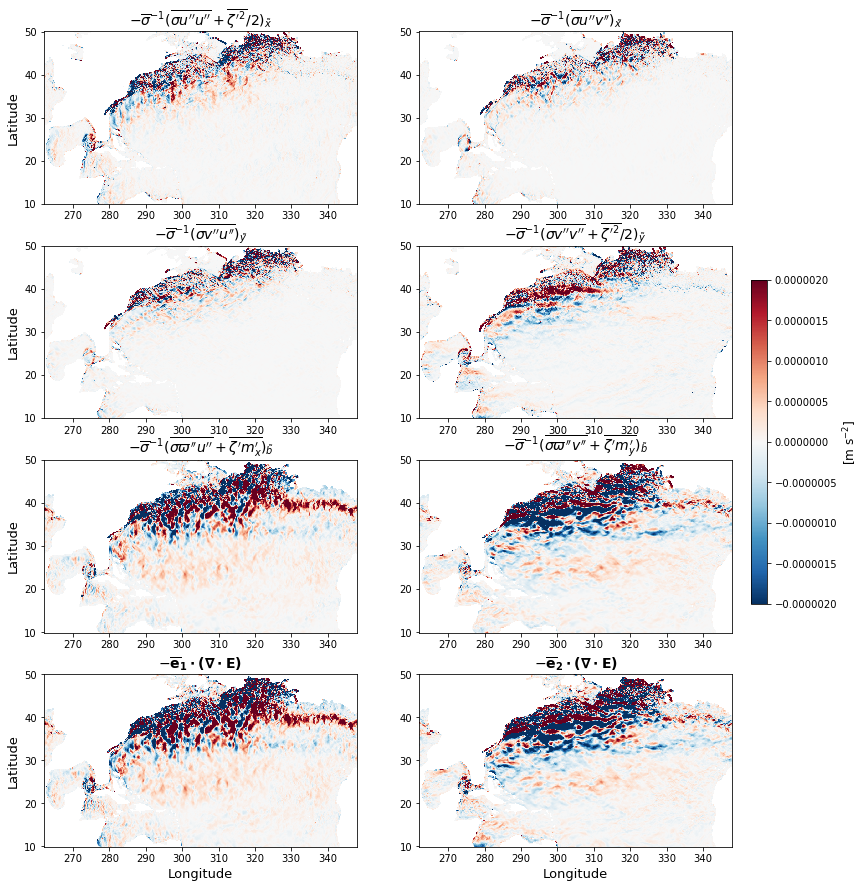

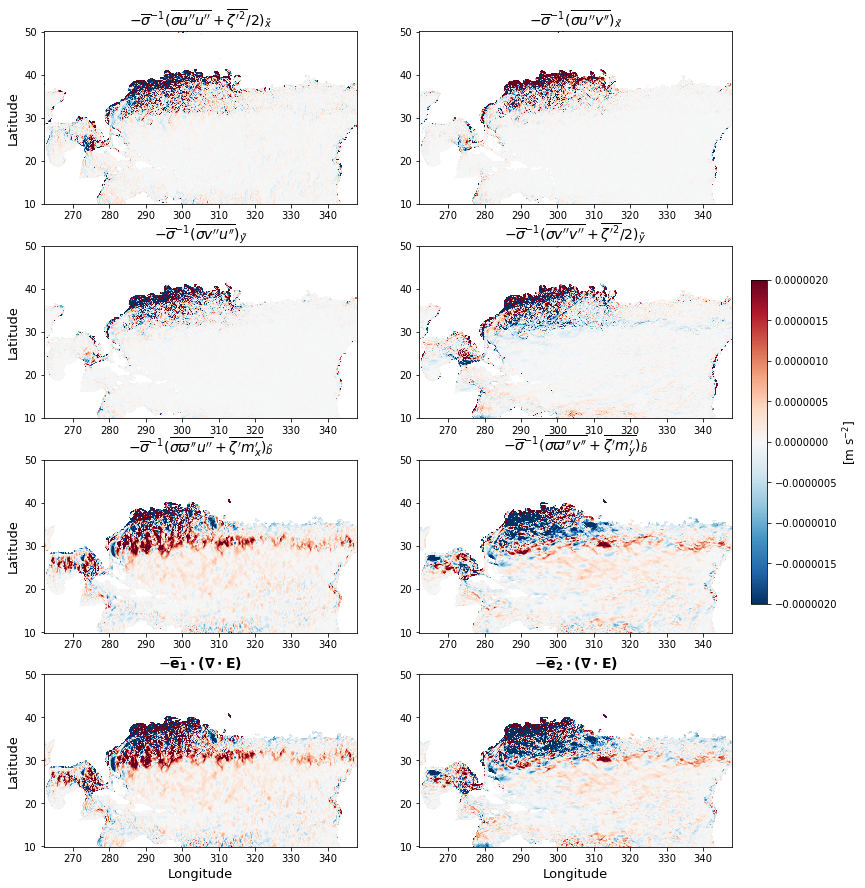

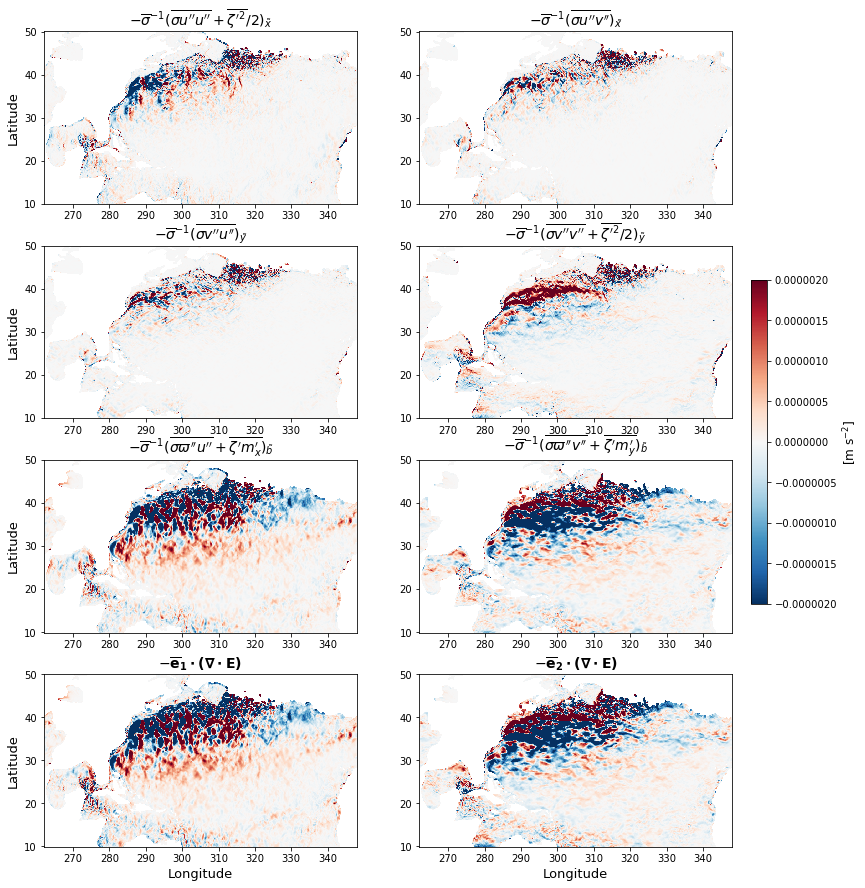

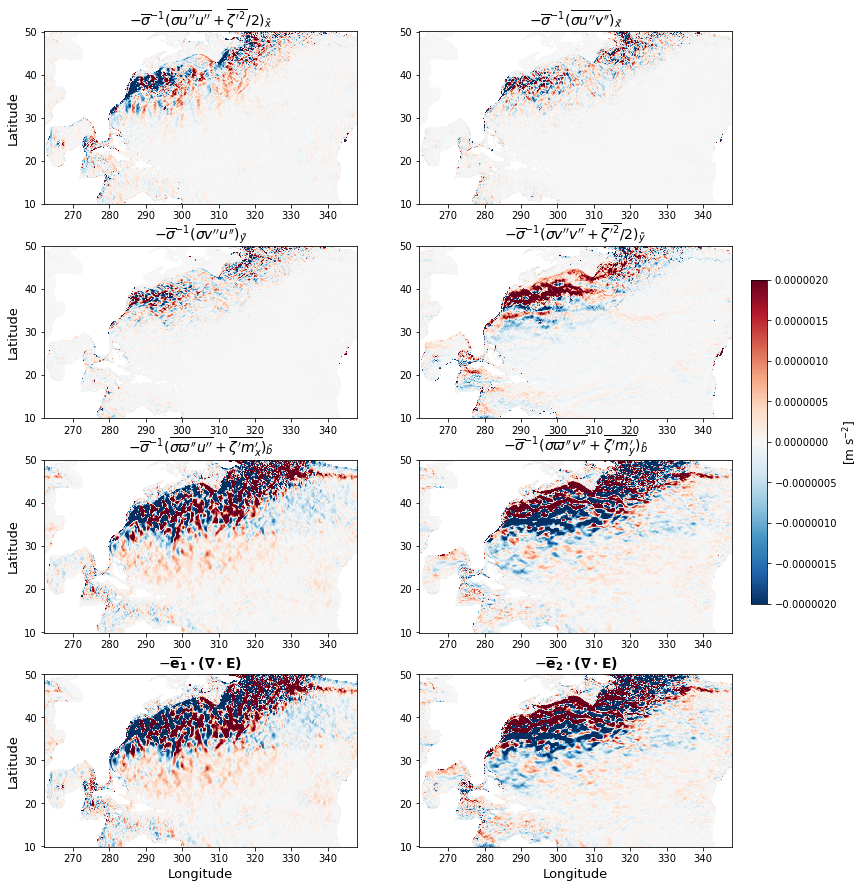

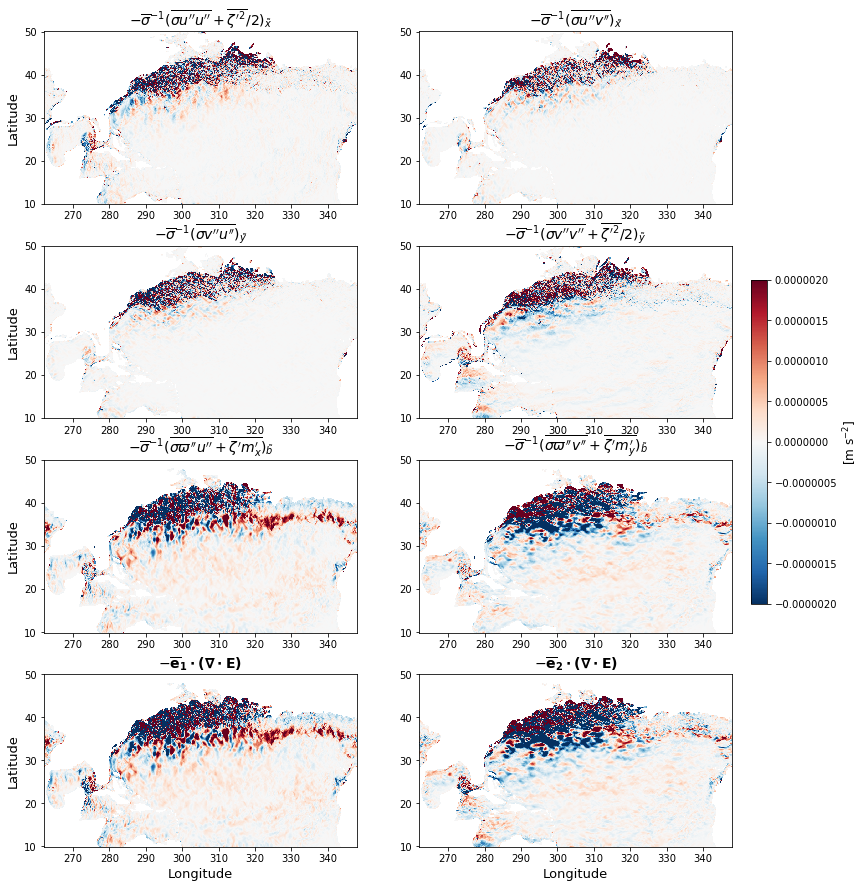

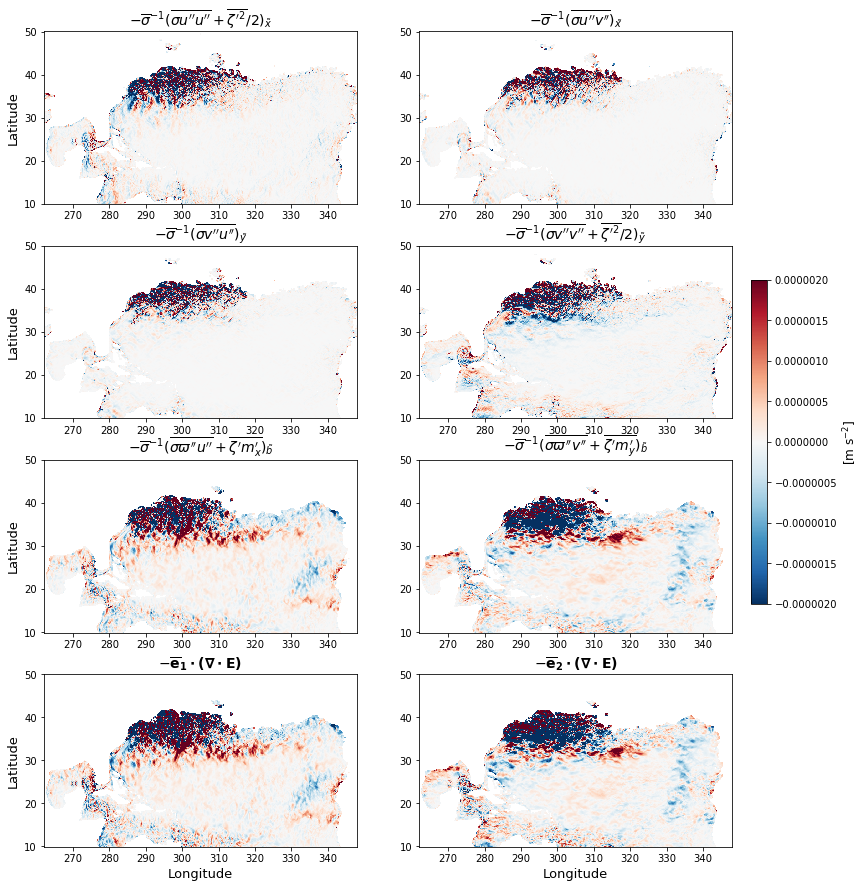

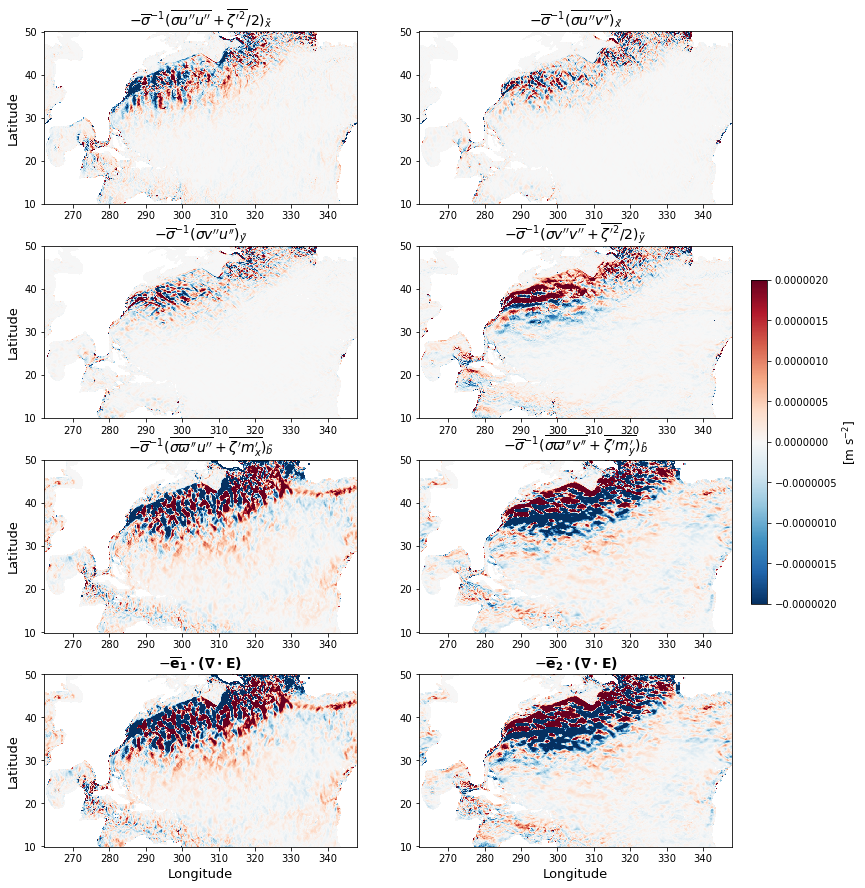

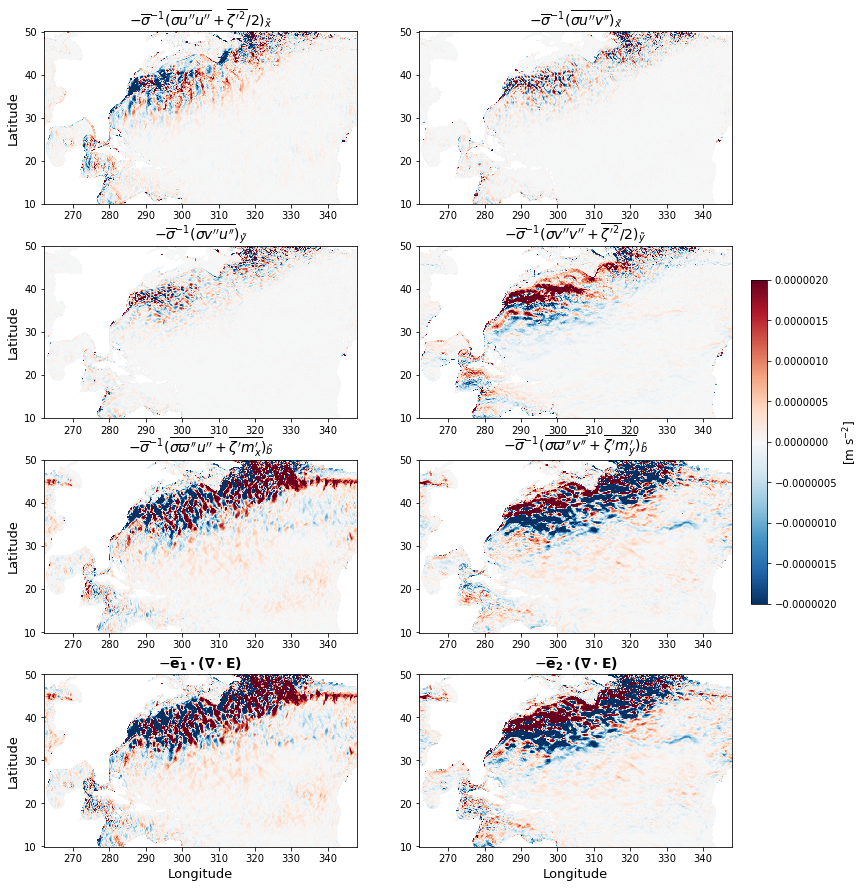

In [8]:
yy = yystart

for year in years[yystart:]:
#     if year == years[yystart]:
#         mtimes = ntimes[yy,dd:]
#         ystart = yNstart
#     else:
#         mtimes = ntimes[yy]
#         ystart = yNstart
    ystart = yNstart
    for itime in mtimes:

#         ds1 = xr.open_dataset(op.join(savedir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
#                                       % (year,nremap,itime))
#                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                    YG=slice(ystart-12**-1,yend+2*12**-1)
#                                   ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
#         ds2 = xr.open_dataset(op.join(savedir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
#                                       % (year,nremap,itime))
#                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                    YG=slice(ystart-12**-1,yend+2*12**-1)
#                                   ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
#         ds3 = xr.open_dataset(op.join(savedir,
#                                       '%4d/Varpidz-compressible_membs_parallel-%2d_%010d.nc' 
#                                       % (year,nremap,itime))
#                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                   ).chunk({'nmemb':membchunk,'XC':xchunk})
        ds1 = xr.open_zarr(op.join(savedir,'5Dave/run%4d/Zs/%010d/' % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               )
        ds2 = xr.open_zarr(op.join(savedir,'5Dave/run%4d/Dyns/%010d/' % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               )
        ds3 = xr.open_zarr(op.join(savedir,'5Dave/run%4d/Varpi/%010d/' % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                               )
        buoyb = -grav * ds1.sig * rhoConst**-1
        buoybp1 = -grav * ds1.sigp1 * rhoConst**-1

        grid = Grid(ds1, periodic=['X'], 
                    coords={'Z':{'center':'sig','outer':'sigp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )

###############################
        dzetaF = ds1.dzetaF.where(ds1.dzetaF!=0.)
        dzetaFy = ds1.dzetaFy.where(ds1.dzetaFy!=0.)
        dzetaFx = ds1.dzetaFx.where(ds1.dzetaFx!=0.)
        sigma = dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmay = dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmax = dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

        zetab = (ds1.zdz*dzetaF**-1).mean('nmemb',skipna=True)
        zetaxb = (ds1.zxdz*dzetaFx**-1).mean('nmemb',skipna=True)
        zetayb = (ds1.zydz*dzetaFy**-1).mean('nmemb',skipna=True)

        sigmab = (dzetaF.mean('nmemb',skipna=True) 
                  * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                 )
        sigmaxb = (dzetaFx.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        sigmayb = (dzetaFy.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        
        varpidz = ds3.diadz + ds3.cmpdz

        vhat = ds2.vdz.mean('nmemb',skipna=True) * dzetaFy.mean('nmemb',skipna=True)**-1
        uhat = ds2.udz.mean('nmemb',skipna=True) * dzetaFx.mean('nmemb',skipna=True)**-1
        varpihat = varpidz.mean('nmemb',skipna=True) * dzetaF.mean('nmemb',skipna=True)**-1

        vpp = ds2.vdz*dzetaFy**-1 - vhat
        upp = ds2.udz*dzetaFx**-1 - uhat
        varpipp = varpidz*dzetaF**-1 - varpihat

        zetap = (ds1.zdz*dzetaF**-1 - zetab) 
        zetayp = (ds1.zydz*dzetaFy**-1 - zetayb)
        zetaxp = (ds1.zxdz*dzetaFx**-1 - zetaxb)

        mbx = ds2.pxdz * dzetaFx**-1
        mby = ds2.pydz * dzetaFy**-1
        mbxp = mbx - mbx.mean('nmemb',skipna=True)
        mbyp = mby - mby.mean('nmemb',skipna=True)

############################### 
#         tmp00 = ((upp**2*sigmax)
#                  + .5*(zetaxp**2)
#                 ).mean('nmemb',skipna=True)
        tmp00_0 = (upp**2*sigmax).mean('nmemb',skipna=True)
        tmp00_1 = .5*(zetaxp**2).mean('nmemb',skipna=True)
#         tmp11 = ((vpp**2*sigmay) 
#                  + .5*(zetayp**2)
#                 ).mean('nmemb',skipna=True)
        tmp11_0 = (vpp**2*sigmay).mean('nmemb',skipna=True)
        tmp11_1 = .5*(zetayp**2).mean('nmemb',skipna=True)
        tmp01 = (grid.interp(grid.interp(vpp,'X'),'Y',boundary='fill')
                 * upp*sigmax).mean('nmemb',skipna=True)
        tmp10 = (grid.interp(grid.interp(upp,'X'),'Y',boundary='fill') 
                 * vpp*sigmay).mean('nmemb',skipna=True)
#         tmp20 = ((varpipp*grid.interp(upp,'X')*sigma)
#                  + grid.interp(mbxp*zetaxp,'X')
#                 ).mean('nmemb',skipna=True)
#         tmp21 = ((varpipp*grid.interp(vpp,'Y',boundary='fill')*sigma)
#                  + grid.interp(mbyp*zetayp,'Y',boundary='fill')
#                 ).mean('nmemb',skipna=True)
        tmp20_0 = (varpipp*grid.interp(upp,'X')
                   * sigma
                  ).mean('nmemb',skipna=True)
        tmp20_1 = grid.interp(mbxp*zetaxp,'X').mean('nmemb',skipna=True)
        tmp21_0 = (varpipp*grid.interp(vpp,'Y',boundary='fill')
                   * sigma
                  ).mean('nmemb',skipna=True)
        tmp21_1 = grid.interp(mbyp*zetayp,'Y',boundary='fill').mean('nmemb',skipna=True)
        if itime == mtimes[0]:
            print(tmp00_0,tmp00_1,tmp11_0,tmp11_1,tmp01,tmp10)
            print(tmp20_0,tmp20_1,tmp21_0,tmp21_1)


###############################    
#         start = time.time()
        e00 = ((tmp00_0+tmp00_1) * sigmaxb**-1).compute()
        e01 = (tmp01 * sigmaxb**-1).compute()
        e10 = (tmp10 * sigmayb**-1).compute()
        e11 = ((tmp11_0+tmp11_1) * sigmayb**-1).compute()
#         e20 = ((tmp20_0+tmp20_1) * sigmab**-1).compute()
#         e21 = ((tmp21_0+tmp21_1) * sigmab**-1).compute()
        e20_0 = (tmp20_0 * sigmab**-1).compute()
        e20_1 = (tmp20_1 * sigmab**-1).compute()
        e21_0 = (tmp21_0 * sigmab**-1).compute()
        e21_1 = (tmp21_1 * sigmab**-1).compute()
    
#         dsave = e00.to_dataset(name='e00')
#         dsave['e01'] = e01
#         dsave['e10'] = e10
#         dsave['e11'] = e11
#         dsave['e20'] = e20
#         dsave['e21'] = e21
#         dsave.coords['YG'] = ('YG',ds1.YG.data)
#         dsave.coords['XG'] = ('XG',ds1.XG.data)
#         dsave.coords['sigp1'] = ('sigp1',ds1.sigp1)
#         dsave.to_netcdf(op.join(savedir,'%4d/E-P_flux_parallel-%2d_%010d.nc' 
#                                 % (year,nremap,itime)), mode='w')
#         dsave.to_zarr(op.join(savedir,'%4d/E-P/%7d' % (year,itime)))
#         dsave.close()

#         del e00, e01, e10, e11, e20_0, e21_0, e20_1, e21_1
###############################  
        e00_x = ((grid.diff(tmp00_0*ds.dyG,'X') * ds.rA**-1
                  + grid.diff(tmp00_1,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1
                 ) * sigmab**-1).compute()
        e10_y = (grid.diff(tmp10*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
                 * sigmab**-1).compute()
#         e20_b = (grid.interp(grid.diff((tmp20_0+tmp20_1),'Z',boundary='fill') 
#                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                              'Z',boundary='fill')
#                  * sigmab**-1).compute()
        e01_x = (grid.diff(tmp01*ds.dyG,'X') * ds.rA**-1 
                 * sigmab**-1).compute()
        e11_y = ((grid.diff(tmp11_0*ds.dxG,'Y',boundary='fill') * ds.rA**-1
                  + grid.diff(tmp11_1,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
                 ) * sigmab**-1).compute()
#         e21_b = (grid.interp(grid.diff((tmp21_0+tmp21_1),'Z',boundary='fill') 
#                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                              'Z',boundary='fill') 
#                  * sigmab**-1).compute()
        e20_0b = (grid.interp(grid.diff(tmp20_0,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        e20_1b = (grid.interp(grid.diff(tmp20_1,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        e21_0b = (grid.interp(grid.diff(tmp21_0,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        e21_1b = (grid.interp(grid.diff(tmp21_1,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        
        if itime % (20*dnf) == 0:
            e20_b = e20_0b + e20_1b
            e21_b = e21_0b + e21_1b
            Eu = e00_x + e10_y + e20_b
            Ev = e01_x + e11_y + e21_b
            if itime == mtimes[0]:
                fig, axes = plt.subplots(figsize=(13,19), nrows=4, ncols=2)
            else:
                fig, axes = plt.subplots(figsize=(13,15), nrows=4, ncols=2)

            im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                      -e00_x.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                      vmax=2.e-6, vmin=-2.e-6, 
                                      cmap='RdBu_r', rasterized=True)
            axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                 -e10_y.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                 -e01_x.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                 -e11_y.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[2,0].pcolormesh(e20_b.XC, e20_b.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                 -e20_b.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[2,1].pcolormesh(e21_b.XC, e21_b.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                 -e21_b.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                 -Eu.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)), 
                                 -Ev.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=16), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='RdBu_r', rasterized=True)

            axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                                fontsize=14)
            axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                                fontsize=14)
            axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                                fontsize=14)
            axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                                fontsize=14)
            axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                                fontsize=14)
            axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                                fontsize=14)
            axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
            axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

            axes[3,0].set_xlabel(r"Longitude", fontsize=13)
            axes[3,1].set_xlabel(r"Longitude", fontsize=13)
            axes[0,0].set_ylabel(r"Latitude", fontsize=13)
            axes[1,0].set_ylabel(r"Latitude", fontsize=13)
            axes[2,0].set_ylabel(r"Latitude", fontsize=13)
            axes[3,0].set_ylabel(r"Latitude", fontsize=13)

            fig.subplots_adjust(right=0.86, hspace=0.24)
            cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
            cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
            cbar.set_label(r"[m s$^{-2}$]", fontsize=12)
            plt.show()

            plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave_%4d-%07d.pdf'
                                % (year,itime)))

#         end = time.time()
#         print("Lapse time:", end-start)

############################### 
        dsave = e00.to_dataset(name='e00')
        dsave['e01'] = e01
        dsave['e10'] = e10
        dsave['e11'] = e11
    #     dsave['e20'] = e20_0 + e20_1
    #     dsave['e21'] = e21_0 + e21_1
        dsave['e00x'] = e00_x
        dsave['e01x'] = e01_x
        dsave['e10y'] = e10_y
        dsave['e11y'] = e11_y
    #     dsave['e20b'] = e20_0b + e20_1b
    #     dsave['e21b'] = e21_0b + e21_1b
        dsave['e20_0'] = e20_0
        dsave['e20_1'] = e20_1
        dsave['e21_0'] = e21_0
        dsave['e21_1'] = e21_1
        dsave['e20_0b'] = e20_0b
        dsave['e20_1b'] = e20_1b
        dsave['e21_0b'] = e21_0b
        dsave['e21_1b'] = e21_1b
        dsave.coords['YG'] = ('YG',ds1.YG.data)
        dsave.coords['XG'] = ('XG',ds1.XG.data)
        dsave.coords['sigp1'] = ('sigp1',ds1.sigp1)
    #     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
    #                             % (year,nremap,itime)), mode='w')
        dsave.to_zarr(op.join(savedir,'5Dave/run%4d/E-P/%010d/' % (year,itime)), mode='w')
        dsave.close()

        del e00, e01, e10, e11
        del e00_x, e01_x, e10_y, e11_y
        del e20_0, e20_1, e21_0, e21_1, e20_0b, e20_1b, e21_0b, e21_1b
        ds1.close()
        ds2.close()
        ds3.close()
        print(itime)
        
    yy += 1
    # client.restart()

In [8]:
year = 1963
nremap = 80
ystart = ySstart

ntimes = np.arange( 943920    , 943920+dnf,dnf,dtype=int)
# ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
# ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
# ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
# ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
for itime in ntimes:
    
    ds1 = xr.open_dataset(op.join(savedir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime))
                         ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                               YG=slice(ystart-12**-1,yend+2*12**-1)
                              ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
    ds2 = xr.open_dataset(op.join(savedir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime))
                         ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                               YG=slice(ystart-12**-1,yend+2*12**-1)
                              ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
    ds3 = xr.open_dataset(op.join(savedir,'%4d/Varpidz-compressible_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime))
                         ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                              ).chunk({'nmemb':membchunk,'XC':xchunk})
#     ds1 = xr.open_zarr(op.join(savedir,'%4d/Zs/%7d' % (year,itime))
#                       ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                             YG=slice(ystart-12**-1,yend+2*12**-1)
#                            )
#     ds2 = xr.open_zarr(op.join(savedir,'%4d/Dyns/%7d' % (year,itime))
#                       ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                             YG=slice(ystart-12**-1,yend+2*12**-1)
#                            )
#     ds3 = xr.open_zarr(op.join(savedir,'%4d/Varpi/%7d' % (year,itime))
#                       ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                            )
    buoyb = -grav * ds1.sig * rhoConst**-1
    buoybp1 = -grav * ds1.sigp1 * rhoConst**-1

    grid = Grid(ds1, periodic=['X'], 
                coords={'Z':{'center':'sig','outer':'sigp1'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
               )
    
###########################    
    sigma = ds1.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
    sigmay = ds1.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
    sigmax = ds1.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

    zetab = (ds1.zdz*ds1.dzetaF**-1).mean('nmemb',skipna=True)
    zetaxb = (ds1.zxdz*ds1.dzetaFx**-1).mean('nmemb',skipna=True)
    zetayb = (ds1.zydz*ds1.dzetaFy**-1).mean('nmemb',skipna=True)
    
    sigmab = (ds1.dzetaF.mean('nmemb',skipna=True) 
              * -grid.diff(buoybp1,'Z',boundary='fill')**-1
             )
    sigmaxb = (ds1.dzetaFx.mean('nmemb',skipna=True) 
               * -grid.diff(buoybp1,'Z',boundary='fill')**-1
              )
    sigmayb = (ds1.dzetaFy.mean('nmemb',skipna=True) 
               * -grid.diff(buoybp1,'Z',boundary='fill')**-1
              )
    
    vhat = ds2.vdz.mean('nmemb',skipna=True) * ds1.dzetaFy.mean('nmemb',skipna=True)**-1
    uhat = ds2.udz.mean('nmemb',skipna=True) * ds1.dzetaFx.mean('nmemb',skipna=True)**-1
    varpihat = ds3.varpidz.mean('nmemb',skipna=True) * ds1.dzetaF.mean('nmemb',skipna=True)**-1

    vpp = ds2.vdz*ds1.dzetaFy**-1 - vhat
    upp = ds2.udz*ds1.dzetaFx**-1 - uhat
    varpipp = ds3.varpidz*ds1.dzetaF**-1 - varpihat

    zetap = (ds1.zdz*ds1.dzetaF**-1 - zetab) 
    zetayp = (ds1.zydz*ds1.dzetaFy**-1 - zetayb)
    zetaxp = (ds1.zxdz*ds1.dzetaFx**-1 - zetaxb)

    mbx = ds2.pxdz * ds1.dzetaFx**-1
    mby = ds2.pydz * ds1.dzetaFy**-1
    mbxp = mbx - mbx.mean('nmemb',skipna=True)
    mbyp = mby - mby.mean('nmemb',skipna=True)
########################### 
    tmp20_0 = (varpipp*grid.interp(upp,'X')
               * sigma
              ).mean('nmemb',skipna=True)
    tmp20_1 = grid.interp(mbxp*zetaxp,'X').mean('nmemb',skipna=True)
    tmp21_0 = (varpipp*grid.interp(vpp,'Y',boundary='fill')
               * sigma
              ).mean('nmemb',skipna=True)
    tmp21_1 = grid.interp(mbyp*zetayp,'Y',boundary='fill').mean('nmemb',skipna=True)

###########################    
    start = time.time()
    e20_0 = (tmp20_0 * sigmab**-1).compute()
    e20_1 = (tmp20_1 * sigmab**-1).compute()
    e21_0 = (tmp21_0 * sigmab**-1).compute()
    e21_1 = (tmp21_1 * sigmab**-1).compute()

###########################  
    e20_0b = (grid.interp(grid.diff(tmp20_0,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    e20_1b = (grid.interp(grid.diff(tmp20_1,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    e21_0b = (grid.interp(grid.diff(tmp21_0,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    e21_1b = (grid.interp(grid.diff(tmp21_1,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    
    end = time.time()
    print("Lapse time:", end-start)
    
    dsave = e20_0.to_dataset(name='varpipup')
    dsave['zpmxp'] = e20_1
    dsave['varpipvp'] = e21_0
    dsave['zpmyp'] = e21_1
    dsave['varpipup_b'] = e20_0b
    dsave['zpmxp_b'] = e20_1b
    dsave['varpipvp_b'] = e21_0b
    dsave['zpmyp_b'] = e21_1b
    dsave.coords['YG'] = ('YG',ds1.YG.data)
    dsave.coords['XG'] = ('XG',ds1.XG.data)
    dsave.coords['sigp1'] = ('sigp1',ds1.sigp1)
#     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
#                             % (year,nremap,itime)), mode='w')
    dsave.to_zarr(op.join(savedir,'%4d/Adiab_barocli/%07d' % (year,itime)))
    dsave.close()
    
    del e20_0, e20_1, e21_0, e21_1
    del e20_0b, e21_0b, e20_1b, e21_1b
    ds1.close()
    ds2.close()
    ds3.close()
    print(itime)
    
# client.restart()

KeyboardInterrupt: 

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('all-aggregate-3990c849e1f1bc2c124f5ff34c0264a4',)": ()}


In [9]:
dsave.to_zarr(op.join(savedir,'%4d/Adiab_barocli/%07d' % (year,itime)))
dsave.close()

# Year 1967

In [8]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0
yystart = 0
ntimes[yystart,dd:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

/tmp/ipykernel_12331/2047231361.py:101: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0].pcolormesh(dzetaFb.XC, dzetaFb.YC.sel(YC=slice(ystart,
/tmp/ipykernel_12331/2047231361.py:107: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(dzetaFyb.XC, dzetaFyb.YG.sel(YG=slice(ystart,
/tmp/ipykernel_12331/2047231361.py:113: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eit

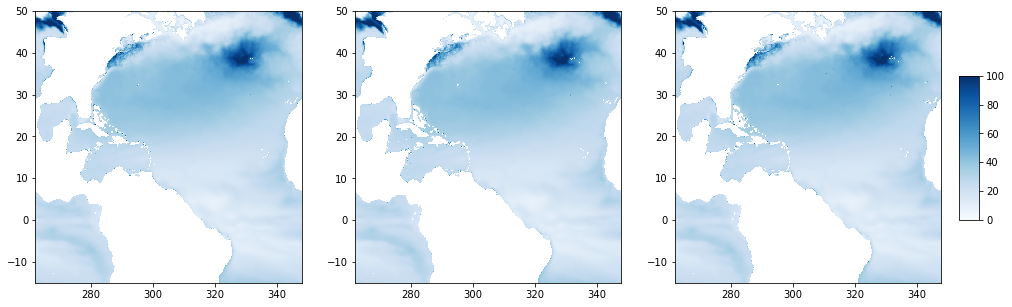

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 783, YG: 783, delta_outer: 55)
Coordinates:
    Depth        (YC, XC) float32 3.225e+03 3.16e+03 ... 2.159e+03 2.125e+03
  * XC           (XC) >f4 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC           (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
    iter         int64 1423440
    maskInC      (YC, XC) bool True True True True True ... True True True True
    rA           (YC, XC) float32 8.559e+07 8.559e+07 ... 5.688e+07 5.688e+07
    time         timedelta64[ns] 3295 days
  * XG           (XG) >f4 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * YG           (YG) >f4 -15.04 -14.96 -14.87 -14.79 ... 49.96 50.04 50.13
Data variables:
    dzetab       (YC, XC, delta_outer) float32 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    dzetaxb      (YC, XG, delta_outer) float32 dask.array<chunksize=(200, 200, 55)

In [9]:
yy = yystart
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))

for year in years[yystart:]:
    
    if year == years[0]:
        mtimes = ntimes[yy,dd+1:]
    else:
        mtimes = ntimes[yy]
    
    for itime in mtimes:
        
#         if itime == ntimes[0,0]:
        ystart = ySstart
#         else:
#             ystart = yNstart
            
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,1967)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                       'YC':ychunk,'YG':ychunk})
            
        for imemb in nmembs:
            
            if imemb == 0:
                ds2 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0)
                delta_outer = ds2.delta_outer
                deltax_outer = ds2.deltax_outer
                deltay_outer = ds2.deltay_outer
            else:
                tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0)
                ds2 = xr.concat([ds2,tmp2], 'nmemb')
        
        ds2.coords['nmemb'] = ('nmemb',range(48))
        
        buoyb = -grav * ds2.delta * rhoConst**-1
        buoybp1 = -grav * ds2.delta_outer * rhoConst**-1

###############################
        dzetaF = ds2.dzetaF.where(ds2.dzetaF!=0.)
        dzetaFy = ds2.dzetaFy.where(ds2.dzetaFy!=0.)
        dzetaFx = ds2.dzetaFx.where(ds2.dzetaFx!=0.)
        
        dzetaFb = dzetaF.mean('nmemb',skipna=True) 
        dzetaFxb = xr.DataArray(dzetaFx.mean('nmemb',skipna=True).data,
                                dims=['YC','XG','delta_outer'],
                                coords={'YC':ds.YC.data,'XG':ds.XG.data,
                                        'delta_outer':ds2.delta_outer.data}
                   )
        dzetaFyb = xr.DataArray(dzetaFy.mean('nmemb',skipna=True).data,
                                dims=['YG','XC','delta_outer'],
                                coords={'YG':ds.YG.data,'XC':ds.XC.data,
                                        'delta_outer':ds2.delta_outer.data}
                   )
        
        zetab = (ds2.zdz*dzetaF**-1).mean('nmemb',skipna=True)
        zetaxb = xr.DataArray((ds2.zxdz*dzetaFx**-1).mean('nmemb',skipna=True).data,
                              dims=['YC','XG','delta_outer'],
                              coords={'YC':ds.YC.data,'XG':ds.XG.data,
                                      'delta_outer':ds2.delta_outer.data}
                 )
        zetayb = xr.DataArray((ds2.zydz*dzetaFy**-1).mean('nmemb',skipna=True).data,
                              dims=['YG','XC','delta_outer'],
                              coords={'YG':ds.YG.data,'XC':ds.XC.data,
                                      'delta_outer':ds2.delta_outer.data}
                 )

#         sigmab = (dzetaF.mean('nmemb',skipna=True) 
#                   * -grid.diff(buoyb,'Z',boundary='extend')**-1
#                  ).compute()
#         sigmaxb = (xr.DataArray(dzetaFx.mean('nmemb',skipna=True).data,
#                                 dims=['YC','XG','delta_outer'],
#                                 coords={'YC':ds.YC.data,
#                                         'XG':ds.XG.data,'delta_outer':ds2.delta_outer.data}
#                   ) * -grid.diff(buoyb,'Z',boundary='extend')**-1).compute()
#         sigmayb = (xr.DataArray(dzetaFy.mean('nmemb',skipna=True).data,
#                                 dims=['YG','XC','delta_outer'],
#                                 coords={'YG':ds.YG.data,
#                                         'XC':ds.XC.data,'delta_outer':ds2.delta_outer.data}
#                   ) * -grid.diff(buoyb,'Z',boundary='extend')**-1).compute()
        
        
        if itime == mtimes[0]:
            fig, axes = plt.subplots(figsize=(17,5), nrows=1, ncols=3)

            im = axes[0].pcolormesh(dzetaFb.XC, dzetaFb.YC.sel(YC=slice(ystart,
                                                                      yend+12**-1)), 
                                    dzetaFb.sel(YC=slice(ystart,
                                                          yend+12**-1)).isel(delta_outer=23), 
                                    vmax=1e2, vmin=0, 
                                    cmap='Blues', rasterized=True)
            axes[1].pcolormesh(dzetaFyb.XC, dzetaFyb.YG.sel(YG=slice(ystart,
                                                                   yend+12**-1)), 
                               dzetaFyb.sel(YG=slice(ystart,
                                                     yend+12**-1)).isel(delta_outer=23), 
                               vmax=1e2, vmin=0,
                               cmap='Blues', rasterized=True)
            axes[2].pcolormesh(dzetaFxb.XG, dzetaFxb.YC.sel(YC=slice(ystart,
                                                                   yend+12**-1)), 
                               dzetaFxb.sel(YC=slice(ystart,
                                                    yend+12**-1)).isel(delta_outer=23), 
                               vmax=1e2, vmin=0,
                               cmap='Blues', rasterized=True)

            fig.subplots_adjust(right=0.865, hspace=0.24)
            cbaxes = fig.add_axes([0.88, 0.3, 0.016, 0.4]) 
            cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
#             cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

#             plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave_%4d-%07d.pdf'
#                                 % (year,itime)))
            plt.show()
    

        dsave = dzetaFb.to_dataset(name='dzetab')
        dsave['dzetaxb'] = dzetaFxb
        dsave['dzetayb'] = dzetaFyb
        dsave['zetab'] = zetab
        dsave['zetaxb'] = zetaxb
        dsave['zetayb'] = zetayb
        if itime == mtimes[0]:
            print(dsave)
#         chunks = {'XC':xchunk,'YC':ychunk,'XG':xchunk,'YG':ychunk}
        dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,
                                                    '5Dave/run%4d/Zetab/%010d/' 
                                        % (year,itime)), mode='w')
        dsave.close()
        

#         end = time.time()
#         print("Lapse time:", end-start)


        ds.close()
        ds2.close()
        print(itime)
        
    yy += 1
    # client.restart()

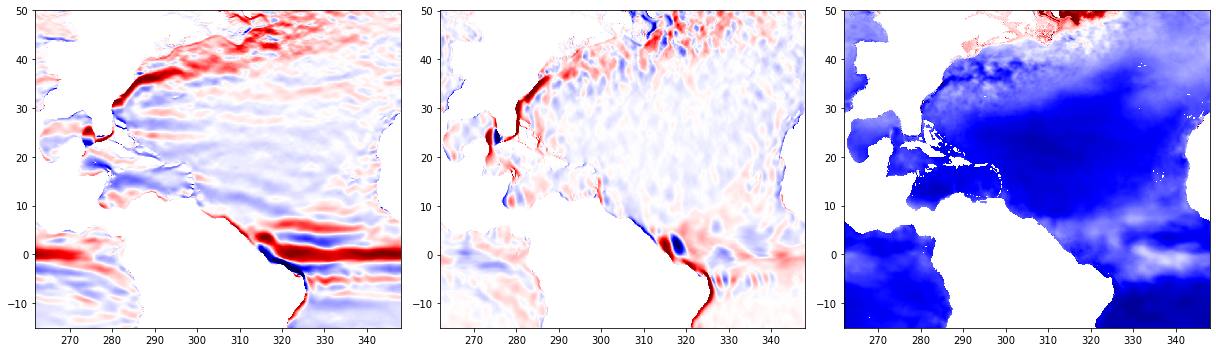

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 783, YG: 783, delta_outer: 55)
Coordinates:
  * YC           (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XG           (XG) >f4 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) >f4 -15.04 -14.96 -14.87 -14.79 ... 49.96 50.04 50.13
  * XC           (XC) >f4 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
Data variables:
    uhat         (YC, XG, delta_outer) float32 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    vhat         (YG, XC, delta_outer) float32 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    varpihat     (YC, XC, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    mbxb         (YC, XG, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    mbyb         (YG, XC, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta

In [7]:
yy = yystart
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))

for year in years[yystart:]:
    
    if year == years[0]:
        mtimes = ntimes[yy,dd+1:]
    else:
        mtimes = ntimes[yy]
    
    for itime in mtimes:
        
#         if itime == ntimes[0,0]:
        ystart = ySstart
#         else:
#             ystart = yNstart
            
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,1967)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                       'YC':ychunk,'YG':ychunk})
        ds5 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)

        dzetab = ds5.dzetab
        dzetaxb = ds5.dzetaxb
        dzetayb = ds5.dzetayb
            
        for imemb in nmembs:
            if imemb == 0:
                ds2 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0)
                ds3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/'
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
                ds4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
            else:
                tmp2 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0)
                ds2 = xr.concat([ds2,tmp2], 'nmemb')
                tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds3 = xr.concat([ds3,tmp3], 'nmemb')
                tmp4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds4 = xr.concat([ds4,tmp4], 'nmemb')
        
        ds2.coords['nmemb'] = ('nmemb',range(48))
        ds3.coords['nmemb'] = ('nmemb',range(48))
        ds4.coords['nmemb'] = ('nmemb',range(48))

###############################
        dzetaFy = ds2.dzetaFy.where(ds2.dzetaFy!=0.)
        dzetaFx = ds2.dzetaFx.where(ds2.dzetaFx!=0.)
        mbx = ds3.pxdz * dzetaFx**-1
        mby = ds3.pydz * dzetaFy**-1
        varpidz = ds4.diadz + ds4.cmpdz

        vhat = xr.DataArray(ds3.vdz.mean('nmemb',skipna=True).data,
                            dims=['YG','XC','delta_outer'],
                            coords={'YG':ds.YG.data,'XC':ds.XC.data,
                                    'delta_outer':ds5.delta_outer.data}
               ) * dzetayb**-1
        uhat = xr.DataArray(ds3.udz.mean('nmemb',skipna=True).data,
                            dims=['YC','XG','delta_outer'],
                            coords={'YC':ds.YC.data,'XG':ds.XG.data,
                                    'delta_outer':ds5.delta_outer.data}
               ) * dzetaxb**-1
        varpihat = (varpidz.mean('nmemb',skipna=True) 
                    * dzetab**-1
                   )
        mbxb = xr.DataArray(mbx.mean('nmemb',skipna=True).data,
                            dims=['YC','XG','delta_outer'],
                            coords={'YC':ds.YC.data,'XG':ds.XG.data,
                                    'delta_outer':ds5.delta_outer.data}
               )
        mbyb = xr.DataArray(mby.mean('nmemb',skipna=True).data,
                            dims=['YG','XC','delta_outer'],
                            coords={'YG':ds.YG.data,'XC':ds.XC.data,
                                    'delta_outer':ds5.delta_outer.data}
               )
        
        
        if itime == mtimes[0]:
            fig, axes = plt.subplots(figsize=(17,5), nrows=1, ncols=3)
            fig.set_tight_layout(True)

            im = axes[0].pcolormesh(uhat.XG, uhat.YC.sel(YC=slice(ystart,
                                                                  yend+12**-1)), 
                                    uhat.sel(YC=slice(ystart,
                                                      yend+12**-1)).isel(delta_outer=23), 
                                    vmax=5e-1, vmin=-5e-1, 
                                    cmap='seismic', rasterized=True)
            axes[1].pcolormesh(vhat.XC, vhat.YG.sel(YG=slice(ystart,
                                                             yend+12**-1)), 
                               vhat.sel(YG=slice(ystart,
                                                 yend+12**-1)).isel(delta_outer=23), 
                               vmax=5e-1, vmin=-5e-1,
                               cmap='seismic', rasterized=True)
            axes[2].pcolormesh(varpihat.XC, varpihat.YC.sel(YC=slice(ystart,
                                                                     yend+12**-1)), 
                               varpihat.sel(YC=slice(ystart,
                                                     yend+12**-1)).isel(delta_outer=23), 
                               vmax=2e-8, vmin=-2e-8,
                               cmap='seismic', rasterized=True)

#             fig.subplots_adjust(right=0.865, hspace=0.24)
#             cbaxes = fig.add_axes([0.88, 0.3, 0.014, 0.4]) 
#             cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)

            plt.show()
    

        dsave = uhat.to_dataset(name='uhat')
        dsave['vhat'] = vhat
        dsave['varpihat'] = varpihat
        dsave['mbxb'] = mbxb
        dsave['mbyb'] = mbyb
        if itime == mtimes[0]:
            print(dsave)
#         chunks = {'XC':xchunk,'YC':ychunk,'XG':xchunk,'YG':ychunk}
        dsave.reset_coords(drop=True).to_zarr(op.join(tdgs,'5Dave/run%4d/Dynb/%010d/' 
                                                      % (year,itime)), mode='w')
        dsave.close()

        ds.close()
        ds2.close()
        ds3.close()
        ds4.close()
        ds5.close()
        print(itime)
        
    yy += 1

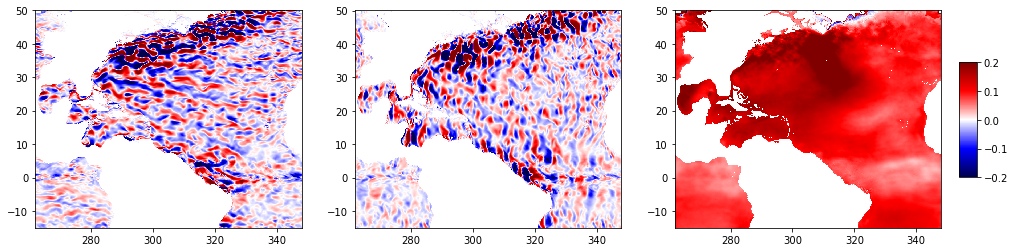

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 783, YG: 783, delta: 54, delta_outer: 55, nmemb: 48)
Coordinates:
  * nmemb        (nmemb) int64 0 1 2 3 4 5 6 7 8 ... 39 40 41 42 43 44 45 46 47
  * YC           (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XG           (XG) >f4 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) >f4 -15.04 -14.96 -14.87 -14.79 ... 49.96 50.04 50.13
  * XC           (XC) >f4 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    upp          (nmemb, YC, XG, delta_outer) float32 dask.array<chunksize=(1, 200, 200, 55), meta=np.ndarray>
    vpp          (nmemb, YG, XC, delta_outer) float32 dask.array<chunksize=(1, 200, 200, 55), meta=np.ndarray>
    varpipp      (nmemb, YC, XC, delta_outer) float64 dask.array<chunksize=(1, 200, 200, 

In [ ]:
yy = yystart
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))

for year in years[yystart:]:
    
    if year == years[0]:
        mtimes = ntimes[yy,dd+1:]
    else:
        mtimes = ntimes[yy]
    
    for itime in mtimes:
#         if itime == ntimes[0,0]:
        ystart = ySstart
#         else:
#             ystart = yNstart
        
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,1967)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                       'YC':ychunk,'YG':ychunk})
        
        ds5 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
        delta = .5*(ds5.delta_outer[1:].data 
                    + ds5.delta_outer[:-1].data)
        ds5.coords['delta'] = ('delta',delta)
        zetab = ds5.zetab.where(ds5.dzetab!=0.)
        zetaxb = ds5.zetaxb.where(ds5.dzetaxb!=0.)
        zetayb = ds5.zetayb.where(ds5.dzetayb!=0.)
       
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynb/%010d/' 
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
        ds7.coords['delta'] = ('delta',delta)
        uhat = ds7.uhat
        vhat = ds7.vhat
        varpihat = ds7.varpihat
        mbxb = ds7.mbxb
        mbyb = ds7.mbyb
            
        for imemb in nmembs:
            
            if imemb == 0:
                ds1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
                ds3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/'
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
                ds4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
                
            else:
                tmp1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds1 = xr.concat([ds1,tmp1], 'nmemb')
                tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds3 = xr.concat([ds3,tmp3], 'nmemb')
                tmp4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds4 = xr.concat([ds4,tmp4], 'nmemb')
        
        ds1.coords['nmemb'] = ('nmemb',range(48))
        ds3.coords['nmemb'] = ('nmemb',range(48))
        ds4.coords['nmemb'] = ('nmemb',range(48))
        
        buoyb = -grav * ds5.delta * rhoConst**-1
        buoybp1 = -grav * ds5.delta_outer * rhoConst**-1


###############################
        dzetaF = ds1.dzetaF.where(ds1.dzetaF!=0.)
        dzetaFy = ds1.dzetaFy.where(ds1.dzetaFy!=0.)
        dzetaFx = ds1.dzetaFx.where(ds1.dzetaFx!=0.)
        
        varpidz = ds4.diadz + ds4.cmpdz

        vpp = xr.DataArray((ds3.vdz*dzetaFy**-1).data, 
                           dims=['nmemb','YG','XC','delta_outer'],
                           coords={'nmemb':ds1.nmemb.data,
                                   'YG':ds.YG.data,'XC':ds.XC.data,
                                   'delta_outer':ds5.delta_outer.data}
              ) - vhat
        upp = xr.DataArray((ds3.udz*dzetaFx**-1).data,
                           dims=['nmemb','YC','XG','delta_outer'],
                           coords={'nmemb':ds1.nmemb.data,
                                   'YC':ds.YC.data,'XG':ds.XG.data,
                                   'delta_outer':ds5.delta_outer.data}
              ) - uhat
        varpipp = varpidz*dzetaF**-1 - varpihat

        zetap = (ds1.zdz*dzetaF**-1 - zetab) 
        zetayp = xr.DataArray((ds1.zydz*dzetaFy**-1).data, 
                              dims=['nmemb','YG','XC','delta_outer'],
                              coords={'nmemb':ds1.nmemb.data,
                                      'YG':ds.YG.data,'XC':ds.XC.data,
                                      'delta_outer':ds5.delta_outer.data}
                 ) - zetayb
        zetaxp = xr.DataArray((ds1.zxdz*dzetaFx**-1).data, 
                              dims=['nmemb','YC','XG','delta_outer'],
                              coords={'nmemb':ds1.nmemb.data,
                                      'YC':ds.YC.data,'XG':ds.XG.data,
                                      'delta_outer':ds5.delta_outer.data}
                 ) - zetaxb

        mbx = ds3.pxdz * dzetaFx**-1
        mby = ds3.pydz * dzetaFy**-1
        mbxp = xr.DataArray(mbx.data, 
                            dims=['nmemb','YC','XG','delta_outer'],
                            coords={'nmemb':ds1.nmemb.data,
                                    'YC':ds.YC.data,'XG':ds.XG.data,
                                    'delta_outer':ds5.delta_outer.data}
               ) - mbxb
        mbyp = xr.DataArray(mby.data,
                            dims=['nmemb','YG','XC','delta_outer'],
                            coords={'nmemb':ds1.nmemb.data,
                                    'YG':ds.YG.data,'XC':ds.XC.data,
                                    'delta_outer':ds5.delta_outer.data}
               ) - mbyb
        
        if itime == mtimes[0]:
            fig, axes = plt.subplots(figsize=(17,4), nrows=1, ncols=3)

            im = axes[0].pcolormesh(upp.XG, upp.YC.sel(YC=slice(ystart,
                                                                yend+12**-1)), 
                                    upp.sel(YC=slice(ystart,
                                                      yend+12**-1)).isel(nmemb=0,delta_outer=23), 
                                    vmax=2e-1, vmin=-2e-1, 
                                    cmap='seismic', rasterized=True)
            axes[1].pcolormesh(vpp.XC, vpp.YG.sel(YG=slice(ystart,
                                                           yend+12**-1)), 
                               vpp.sel(YG=slice(ystart,
                                                 yend+12**-1)).isel(nmemb=0,delta_outer=23), 
                               vmax=2e-1, vmin=-2e-1,
                               cmap='seismic', rasterized=True)
            axes[2].pcolormesh(varpipp.XC, varpipp.YC.sel(YC=slice(ystart,
                                                                   yend+12**-1)), 
                               varpipp.sel(YC=slice(ystart,
                                                     yend+12**-1)).isel(nmemb=0,delta_outer=23), 
                               vmax=2e-8, vmin=-2e-8,
                               cmap='seismic', rasterized=True)

            fig.subplots_adjust(right=0.865, hspace=0.24)
            cbaxes = fig.add_axes([0.88, 0.3, 0.014, 0.4]) 
            cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
#             cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

#             plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave_%4d-%07d.pdf'
#                                 % (year,itime)))
            plt.show()
    
###############################    
        dsave = upp.to_dataset(name='upp')
        dsave['vpp'] = vpp
        dsave['varpipp'] = varpipp
        dsave['zetap'] = zetap
    #     dsave['e20'] = e20_0 + e20_1
    #     dsave['e21'] = e21_0 + e21_1
        dsave['zetayp'] = zetayp
        dsave['zetaxp'] = zetaxp
        dsave['mbxp'] = mbxp
        dsave['mbyp'] = mbyp
        dsave = dsave.reset_coords(drop=True)
        dsave.coords['YG'] = ('YG',ds.YG.data)
        dsave.coords['XG'] = ('XG',ds.XG.data)
        dsave.coords['delta'] = ('delta',delta)
        if itime == mtimes[0]:
            print(dsave)
    #     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
    #                             % (year,nremap,itime)), mode='w')
        chunks = {'XC':xchunk,'YC':ychunk,'XG':xchunk,'YG':ychunk}
        dsave.chunk(chunks).to_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/' 
                                            % (year,itime)), mode='w')
        dsave.close()
        
        ds.close()
        ds1.close()
        ds3.close()
        ds4.close()
        ds5.close()
        ds7.close()
        print(itime)
        
    yy += 1
    # client.restart()

<xarray.Dataset>
Dimensions:      (XC: 1000, XG: 1000, YC: 783, YG: 783, delta_outer: 55)
Coordinates:
  * XG           (XG) float32 262.0 262.0 262.1 262.2 ... 347.8 347.8 347.9
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
  * YG           (YG) float32 -15.04 -14.96 -14.87 -14.79 ... 49.96 50.04 50.13
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
Data variables:
    e00          (YC, XG, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    e01          (YC, XG, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    e10          (YG, XC, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    e11          (YG, XC, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    e20_0        (YC, XC, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=n

/tmp/ipykernel_26886/3736538130.py:262: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart,yend+12**-1)),
/tmp/ipykernel_26886/3736538130.py:266: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ystart,yend+12**-1)),
/tmp/ipykernel_26886/3736538130.py:270: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is depr

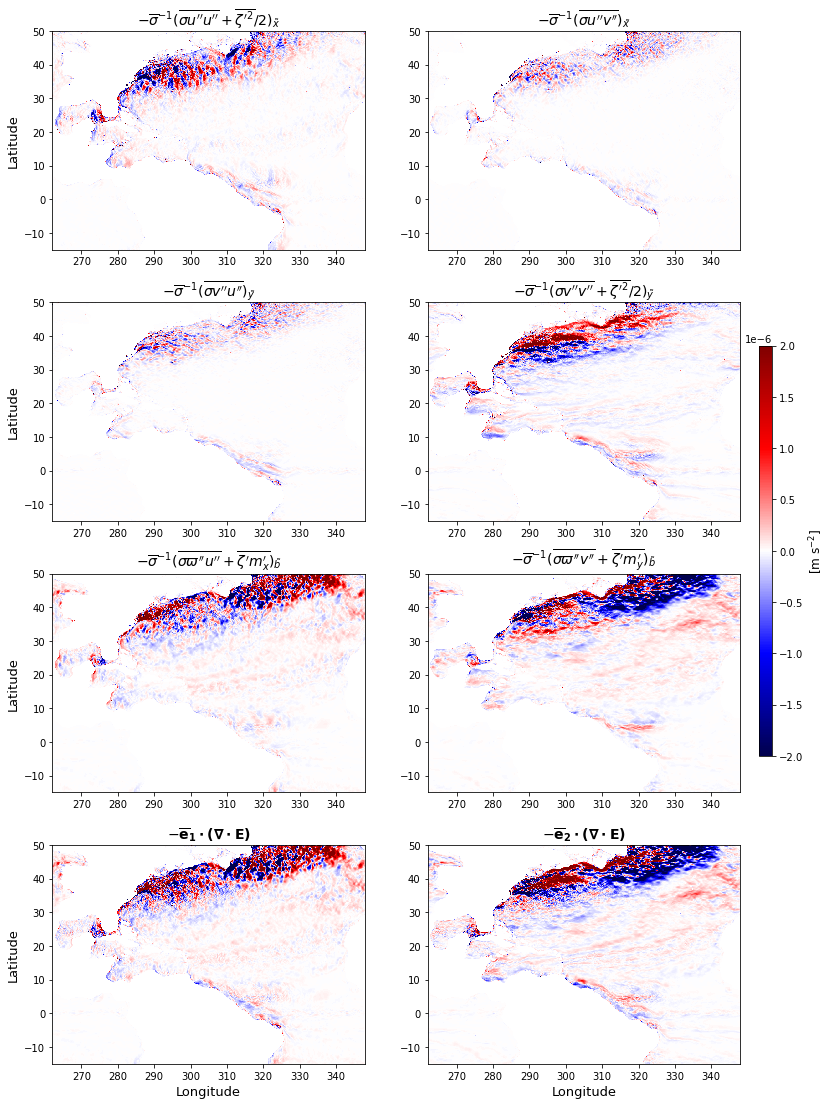

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 783, delta_outer: 55)
Coordinates:
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Data variables:
    e00x         (YC, XC, delta_outer) float64 dask.array<chunksize=(199, 199, 55), meta=np.ndarray>
    e01x         (YC, XC, delta_outer) float64 dask.array<chunksize=(200, 199, 55), meta=np.ndarray>
    e10y         (YC, XC, delta_outer) float64 dask.array<chunksize=(199, 200, 55), meta=np.ndarray>
    e11y         (YC, XC, delta_outer) float64 dask.array<chunksize=(199, 199, 55), meta=np.ndarray>
    e20_0b       (YC, XC, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    e20_1b       (YC, XC, delta_outer) float64 dask.array<chunksize=(200, 200, 55), meta=np.ndarray>
    e21_0b       (YC, XC, delta_outer) float64 dask.array<chunk

In [54]:
yy = yystart
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))

for year in years[yystart:]:
    
    if year == years[0]:
        mtimes = ntimes[yy,dd+1:]
#         ystart = yNstart
    else:
        mtimes = ntimes[yy]
#         ystart = yNstart
    
    for itime in mtimes:
#         if itime == ntimes[0,0]:
        ystart = ySstart
#         else:
#             ystart = yNstart
        
        ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                     % (0,1967)), 
                             grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                             iters=itime,
                             prefix=['diag_ocnTave'], delta_t=2e2,
                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                 ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                       'YC':ychunk,'YG':ychunk})
        
        ds5 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Zetab/%010d/' 
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
        delta = .5*(ds5.delta_outer[1:].data 
                    + ds5.delta_outer[:-1].data)
        ds5.coords['delta'] = ('delta',delta)
        zetab = ds5.zetab
        zetaxb = ds5.zetaxb
        zetayb = ds5.zetayb
        dzetab = ds5.dzetab.where(ds5.dzetab!=0.)
        dzetaxb = ds5.dzetaxb.where(ds5.dzetaxb!=0.)
        dzetayb = ds5.dzetayb.where(ds5.dzetayb!=0.)
        sigmab = (dzetab * -grid.diff(buoyb,'Z',boundary='extend')**-1)
        sigmaxb = (dzetaxb * -grid.diff(buoyb,'Z',boundary='extend')**-1)
        sigmayb = (dzetayb * -grid.diff(buoyb,'Z',boundary='extend')**-1)
        
        ds6 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/%010d/' 
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
        ds6.coords['delta'] = ('delta',delta)
        upp = ds6.upp
        vpp = ds6.vpp
        varpipp = ds6.varpipp
        zetap = ds6.zetap
        zetayp = ds6.zetayp
        zetaxp = ds6.zetaxp
        mbyp = ds6.mbyp
        mbxp = ds6.mbxp
       
        ds7 = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynb/%010d/' 
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)
        ds7.coords['delta'] = ('delta',delta)
        uhat = ds7.uhat
        vhat = ds7.vhat
        varpihat = ds7.varpihat
            
        for imemb in nmembs:
            
            if imemb == 0:
                ds1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
                ds3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/'
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
                ds4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                           % (year,imemb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                       ).isel(time=0).reset_coords(drop=True)
                
            else:
                tmp1 = xr.open_zarr(op.join(tdgs,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds1 = xr.concat([ds1,tmp1], 'nmemb')
                tmp3 = xr.open_zarr(op.join(tdgs,'5Dave/Dyns/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                         YG=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds3 = xr.concat([ds3,tmp3], 'nmemb')
                tmp4 = xr.open_zarr(op.join(tdgs,'5Dave/Varpi/run%4d/memb%02d/%010d/' 
                                            % (year,imemb,itime))
                                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                                        ).isel(time=0).reset_coords(drop=True)
                ds4 = xr.concat([ds4,tmp4], 'nmemb')
        
        ds1.coords['nmemb'] = ('nmemb',range(48))
        ds3.coords['nmemb'] = ('nmemb',range(48))
        ds4.coords['nmemb'] = ('nmemb',range(48))
#         ds5.coords['nmemb'] = ('nmemb',range(48))
        
        buoyb = -grav * ds5.delta * rhoConst**-1
        buoybp1 = -grav * ds5.delta_outer * rhoConst**-1

        grid = Grid(ds5, periodic=['X'], 
                    coords={'Z':{'center':'delta','outer':'delta_outer'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )

###############################
        dzetaF = ds1.dzetaF.where(ds1.dzetaF!=0.)
        dzetaFy = ds1.dzetaFy.where(ds1.dzetaFy!=0.)
        dzetaFx = ds1.dzetaFx.where(ds1.dzetaFx!=0.)
        sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='extend')**-1
        sigmay = xr.DataArray(dzetaFy.data, 
                              dims=['nmemb','YG','XC','delta_outer'],
                              coords={'nmemb':ds1.nmemb.data,
                                      'YG':ds.YG.data,'XC':ds.XC.data,
                                      'delta_outer':ds5.delta_outer.data}
                 ) * -grid.diff(buoyb,'Z',boundary='extend')**-1
        sigmax = xr.DataArray(dzetaFx.data, 
                              dims=['nmemb','YC','XG','delta_outer'],
                              coords={'nmemb':ds1.nmemb.data,
                                      'YC':ds.YC.data,'XG':ds.XG.data,
                                      'delta_outer':ds5.delta_outer.data}
                 ) * -grid.diff(buoyb,'Z',boundary='extend')**-1

############################### 
#         tmp00 = ((upp**2*sigmax)
#                  + .5*(zetaxp**2)
#                 ).mean('nmemb',skipna=True)
        tmp00_0 = (upp**2*sigmax).mean('nmemb',skipna=True).compute()
        tmp00_1 = .5*(zetaxp**2).mean('nmemb',skipna=True).compute()
#         tmp11 = ((vpp**2*sigmay) 
#                  + .5*(zetayp**2)
#                 ).mean('nmemb',skipna=True)
        tmp11_0 = (vpp**2*sigmay).mean('nmemb',skipna=True).compute()
        tmp11_1 = .5*(zetayp**2).mean('nmemb',skipna=True).compute()
        tmp01 = (grid.interp(grid.interp(vpp,'X'),'Y',boundary='fill')
                 * upp*sigmax).mean('nmemb',skipna=True).compute()
        tmp10 = (grid.interp(grid.interp(upp,'X'),'Y',boundary='fill') 
                 * vpp*sigmay).mean('nmemb',skipna=True).compute()
#         tmp20 = ((varpipp*grid.interp(upp,'X')*sigma)
#                  + grid.interp(mbxp*zetaxp,'X')
#                 ).mean('nmemb',skipna=True)
#         tmp21 = ((varpipp*grid.interp(vpp,'Y',boundary='fill')*sigma)
#                  + grid.interp(mbyp*zetayp,'Y',boundary='fill')
#                 ).mean('nmemb',skipna=True)
        tmp20_0 = (varpipp*grid.interp(upp,'X')
                   * sigma
                  ).mean('nmemb',skipna=True).compute()
        tmp20_1 = grid.interp(mbxp*zetaxp,'X').mean('nmemb',skipna=True).compute()
        tmp21_0 = (varpipp*grid.interp(vpp,'Y',boundary='fill')
                   * sigma
                  ).mean('nmemb',skipna=True).compute()
        tmp21_1 = grid.interp(mbyp*zetayp,'Y',boundary='fill').mean('nmemb',skipna=True).compute()
#         if itime == mtimes[0]:
#             print(tmp00_0,tmp00_1,tmp11_0,tmp11_1)
#             print(tmp01,tmp10)
#             print(tmp20_0,tmp20_1,tmp21_0,tmp21_1)

###############################    
#         start = time.time()
        e00 = ((tmp00_0+tmp00_1) * sigmaxb**-1)
        e01 = (tmp01 * sigmaxb**-1)
        e10 = (tmp10 * sigmayb**-1)
        e11 = ((tmp11_0+tmp11_1) * sigmayb**-1)
#         e20 = ((tmp20_0+tmp20_1) * sigmab**-1).compute()
#         e21 = ((tmp21_0+tmp21_1) * sigmab**-1).compute()
        e20_0 = (tmp20_0 * sigmab**-1)
        e20_1 = (tmp20_1 * sigmab**-1)
        e21_0 = (tmp21_0 * sigmab**-1)
        e21_1 = (tmp21_1 * sigmab**-1)
    

        dsave = e00.to_dataset(name='e00')
        dsave['e01'] = e01
        dsave['e10'] = e10
        dsave['e11'] = e11
    #     dsave['e20'] = e20_0 + e20_1
    #     dsave['e21'] = e21_0 + e21_1
        dsave['e20_0'] = e20_0
        dsave['e20_1'] = e20_1
        dsave['e21_0'] = e21_0
        dsave['e21_1'] = e21_1
        dsave = dsave.reset_coords(drop=True)
#         dsave.coords['YG'] = ('YG',ds.YG.data)
#         dsave.coords['XG'] = ('XG',ds.XG.data)
#         dsave.coords['delta'] = ('delta',delta)
        if itime == mtimes[0]:
            print(dsave)
    #     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
    #                             % (year,nremap,itime)), mode='w')
        chunks = {'XC':xchunk,'YC':ychunk,'XG':xchunk,'YG':ychunk}
        dsave.chunk(chunks).to_zarr(op.join(tdgs,'5Dave/run%4d/E-P/%010d/' 
                                            % (year,itime)), mode='w')
        dsave.close()
        del e00, e01, e10, e11, e20_0, e21_0, e20_1, e21_1
        
###############################  
        e00_x = ((grid.diff(tmp00_0*ds.dyG,'X') * ds.rA**-1
                  + grid.diff(tmp00_1,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1
                 ) * sigmab**-1)
        e10_y = (grid.diff(tmp10*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
                 * sigmab**-1)
#         e20_b = (grid.interp(grid.diff((tmp20_0+tmp20_1),'Z',boundary='fill') 
#                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                              'Z',boundary='fill')
#                  * sigmab**-1).compute()
        e01_x = (grid.diff(tmp01*ds.dyG,'X') * ds.rA**-1 
                 * sigmab**-1)
        e11_y = ((grid.diff(tmp11_0*ds.dxG,'Y',boundary='fill') * ds.rA**-1
                  + grid.diff(tmp11_1,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
                 ) * sigmab**-1)
#         e21_b = (grid.interp(grid.diff((tmp21_0+tmp21_1),'Z',boundary='fill') 
#                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                              'Z',boundary='fill') 
#                  * sigmab**-1).compute()
        e20_0b = (grid.interp(grid.diff(tmp20_0,'Z',boundary='fill') 
                              * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1)
        e20_1b = (grid.interp(grid.diff(tmp20_1,'Z',boundary='fill') 
                              * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1)
        e21_0b = (grid.interp(grid.diff(tmp21_0,'Z',boundary='fill') 
                              * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1)
        e21_1b = (grid.interp(grid.diff(tmp21_1,'Z',boundary='fill') 
                              * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1)
        
        if itime == mtimes[0]:
            e20_b = e20_0b + e20_1b
            e21_b = e21_0b + e21_1b
            Eu = e00_x + e10_y + e20_b
            Ev = e01_x + e11_y + e21_b
            fig, axes = plt.subplots(figsize=(13,19), nrows=4, ncols=2)
        elif itime % (20*dnf) == 0:
            e20_b = e20_0b + e20_1b
            e21_b = e21_0b + e21_1b
            Eu = e00_x + e10_y + e20_b
            Ev = e01_x + e11_y + e21_b
            fig, axes = plt.subplots(figsize=(13,15), nrows=4, ncols=2)
        if itime == mtimes[0] or itime % (20*dnf) == 0:
            im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                      -e00_x.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                      vmax=2.e-6, vmin=-2.e-6, 
                                      cmap='seismic', rasterized=True)
            axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                 -e10_y.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='seismic', rasterized=True)
            axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                 -e01_x.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='seismic', rasterized=True)
            axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                 -e11_y.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='seismic', rasterized=True)
            axes[2,0].pcolormesh(e20_b.XC, e20_b.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                 -e20_b.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='seismic', rasterized=True)
            axes[2,1].pcolormesh(e21_b.XC, e21_b.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                 -e21_b.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='seismic', rasterized=True)
            axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                 -Eu.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='seismic', rasterized=True)
            axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart,yend+12**-1)), 
                                 -Ev.sel(YC=slice(ystart,yend+12**-1)).isel(delta_outer=23), 
                                 vmax=2.e-6, vmin=-2.e-6, 
                                 cmap='seismic', rasterized=True)

            axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                                fontsize=14)
            axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                                fontsize=14)
            axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                                fontsize=14)
            axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                                fontsize=14)
            axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                                fontsize=14)
            axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                                fontsize=14)
            axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
            axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

            axes[3,0].set_xlabel(r"Longitude", fontsize=13)
            axes[3,1].set_xlabel(r"Longitude", fontsize=13)
            axes[0,0].set_ylabel(r"Latitude", fontsize=13)
            axes[1,0].set_ylabel(r"Latitude", fontsize=13)
            axes[2,0].set_ylabel(r"Latitude", fontsize=13)
            axes[3,0].set_ylabel(r"Latitude", fontsize=13)

            fig.subplots_adjust(right=0.86, hspace=0.24)
            cbaxes = fig.add_axes([0.88, 0.35, 0.014, 0.3]) 
            cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
            cbar.set_label(r"[m s$^{-2}$]", fontsize=12)
#             plt.savefig(op.join(savedir,'Figures/DivE-P_flux_5Dave_%4d-%07d.pdf'
#                                 % (year,itime)))
            plt.show()

#         end = time.time()
#         print("Lapse time:", end-start)


        dsave = e00_x.to_dataset(name='e00x')
        dsave['e01x'] = e01_x
        dsave['e10y'] = e10_y
        dsave['e11y'] = e11_y
    #     dsave['e20b'] = e20_0b + e20_1b
    #     dsave['e21b'] = e21_0b + e21_1b
        dsave['e20_0b'] = e20_0b
        dsave['e20_1b'] = e20_1b
        dsave['e21_0b'] = e21_0b
        dsave['e21_1b'] = e21_1b
        dsave = dsave.reset_coords(drop=True)
#         dsave.coords['YG'] = ('YG',ds.YG.data)
#         dsave.coords['XG'] = ('XG',ds.XG.data)
#         dsave.coords['delta'] = ('delta',delta)
        if itime == mtimes[0]:
            print(dsave)
    #     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
    #                             % (year,nremap,itime)), mode='w')
        chunks = {'XC':xchunk,'YC':ychunk,'delta_outer':-1}
        dsave.chunk(chunks).to_zarr(op.join(tdgs,'5Dave/run%4d/divE-P/%010d/' 
                                            % (year,itime)), mode='w')
        dsave.close()

        del e00_x, e01_x, e10_y, e11_y
        del e20_0b, e20_1b, e21_0b, e21_1b
        del tmp00_0, tmp00_1, tmp11_0, tmp11_1
        del tmp01, tmp10
        del tmp20_0, tmp20_1, tmp21_0, tmp21_1
        del sigmab, sigmaxb, sigmayb
        ds.close()
        ds1.close()
        ds3.close()
        ds4.close()
        ds5.close()
        ds6.close()
        ds7.close()
        print(itime)
        
    yy += 1
    # client.restart()

In [ ]:
client.close()